# Multi abstract classifier

In [212]:
import matplotlib.pyplot as plt
import urllib
import feedparser
import random
import os
import time
import pandas as pd

from wordcloud import WordCloud
%matplotlib inline

## Functions

In [213]:
def search_abstracts(search_query, start, max_results):
    ''' Access the Arxiv API and return a collection of papers.
        
        Arguments:
        search_query -- paper topic
        start -- the starting point of papers to be selected
        max_results -- max number of papers to be returned
        
    '''
    # calling the api: http://export.arxiv.org/api/{method_name}?{parameters}
    base_url = 'https://export.arxiv.org/api/query?';

    query = 'search_query=%s&start=%i&max_results=%i' % (search_query,
                                                     start,
                                                     max_results)

    feedparser._FeedParserMixin.namespaces['http://a9.com/-/spec/opensearch/1.1/'] = 'opensearch'
    feedparser._FeedParserMixin.namespaces['http://arxiv.org/schemas/atom'] = 'arxiv'

    # perform a GET request using the base_url and query
    response = urllib.request.urlopen(base_url+query).read()
    feed = feedparser.parse(response)
    return feed

In [214]:
def create_files():
    physics_feed = search_abstracts('all:physics', start = 3000, max_results = 50)
    math_feed = search_abstracts('all:math', start = 3000, max_results = 50)
    chem_feed = search_abstracts('all:chemistry', start = 3000, max_results = 50)

    physics_abstracts = [entry.summary for entry in physics_feed.entries]
    math_abstracts = [entry.summary for entry in math_feed.entries]
    chem_abstracts = [entry.summary for entry in chem_feed.entries]

    all_abst = physics_abstracts + math_abstracts + chem_abstracts

    random.shuffle(all_abst)

    # get current directory
    current_dir = os.getcwd()
    new_folder_path = current_dir+os.sep+'Multi_abstracts_files'
    try:
        os.mkdir(new_folder_path)
    except FileExistsError:
        pass
    
    for abstr in range(len(all_abst)):
        name = 'file'+'_'+str(abstr)+'.txt'
        with open(new_folder_path+os.sep+name, 'w') as f:
            f.write(all_abst[abstr])
    return new_folder_path

In [215]:
def classify_abstract(path_to_files, classifier, tff):
    for file in os.listdir(path_to_files):
        with open(path_to_files+os.sep+file, 'r') as f:
            
            trans = tff.transform([f.read()]).toarray()
            
            abstr_class = classifier.predict(trans)
      
            if abstr_class == 0:
                abstr_class = 'physics'
            if abstr_class == 1:
                abstr_class = 'math'
            if abstr_class == 2:
                abstr_class = 'chemistry'
                
            abstr_class_path = path_to_files+os.sep+abstr_class+'_abstracts'
            
            try:
                os.mkdir(abstr_class_path)
            except FileExistsError:
                pass
            os.rename(f.name, abstr_class_path+os.sep+abstr_class+'_'+file)

In [216]:
def createWordCloud(words, stopwords):
    wordcloud = WordCloud(max_words = 20, stopwords = stopwords)
    wordcloud.generate(' '.join(words))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
    plt.show()

In [217]:
st = time.time()
# Search for physics, math, chemistry papers
physics_feed = search_abstracts('all:physics', start = 0, max_results = 3000)
math_feed = search_abstracts('all:math', start = 0, max_results = 3000)
chem_feed = search_abstracts('all:chemistry', start = 0, max_results= 3000)

In [218]:
# Create dictionaries for each topic
physics_abstracts = { 'Types': ['Physics' for _ in range(len(physics_feed.entries))],
                     'Labels': [ 0 for _ in range(len(physics_feed.entries))], 
                    'Abstracts': [entry.summary for entry in physics_feed.entries]}

math_abstracts = { 'Types': ['Math' for _ in range(len(math_feed.entries))],
                    'Labels': [ 1 for _ in range(len(math_feed.entries))], 
                    'Abstracts': [entry.summary for entry in math_feed.entries]}

chem_abstracts = { 'Types': ['Chemistry' for _ in range(len(chem_feed.entries))],
                'Labels': [ 2 for _ in range(len(chem_feed.entries))], 
                    'Abstracts': [entry.summary for entry in chem_feed.entries]}

In [219]:
# Place all topics in panda dataframe
physics_df = pd.DataFrame(physics_abstracts)
math_df = pd.DataFrame(math_abstracts)
chem_df = pd.DataFrame(chem_abstracts)
frames = [physics_df, math_df, chem_df]
all_df = pd.concat(frames)
all_df = all_df.sample(frac =1).reset_index(drop = True)

In [220]:
# Used to obtain a Term-frequency, Inverser Document frequency matrix of features from raw documents  

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf = True, lowercase = True, min_df = 5, norm = 'l2', encoding = 'latin-1', 
                       ngram_range = (1,2), stop_words = 'english')
features = tfidf.fit_transform(all_df.Abstracts).toarray()
labels = all_df.Labels

In [221]:
# Use chi2 score to select the features with the highest values
# find terms that are most correlated to each area

from sklearn.feature_selection import chi2
import numpy as np
N = 3
for i in range(3):
    features_chi2 = chi2(features, labels == i)
    chi2_indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[chi2_indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("Area:", all_df.Types[all_df.Labels == i].values[0])
    print("Most correlated unigrams:", ', '.join(unigrams[-N:]))
    print("Most correlated bigrams:", ', '.join(bigrams[-N:]))
    print('*'*20)

Area: Physics
Most correlated unigrams: chemistry, physical, physics
Most correlated bigrams: particle physics, standard model, new physics
********************
Area: Math
Most correlated unigrams: physics, prove, math
Most correlated bigrams: new physics, math soc, math phys
********************
Area: Chemistry
Most correlated unigrams: molecular, chemical, chemistry
Most correlated bigrams: physics chemistry, gas phase, quantum chemistry
********************


In [222]:
#Split the data into training and test data
from sklearn.model_selection import train_test_split

# Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer

# Transform a count matrix to a normalized tf or tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

#
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(all_df['Abstracts'], all_df['Types'],test_size= 0.1, random_state = 0)

# Use CountVectorizer followed by TfidfTransformer
count_vect = CountVectorizer(lowercase = True, stop_words ='english', min_df = 5)
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Apply model
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [223]:
X_test.values[0]

"Many {\\it ribosomes} simultaneously move on the same messenger RNA (mRNA),\neach synthesizing separately a copy of the same protein. In contrast to the\nearlier models, here {\\it we develop a ``unified'' theoretical model} that not\nonly incorporates the {\\it mutual exclusions} of the interacting ribosomes, but\nalso describes explicitly the mechano-chemistry of each of these macromolecular\nmachines during protein synthesis. Using analytical and numerical techniques of\nnon-equilibrium statistical mechanics, we analyze the rates of protein\nsynthesis and the spatio-temporal organization of the ribosomes in this model.\nWe also predict how these properties would change with the changes in the rates\nof the various chemo-mechanical processes in each ribosome. Finally, we\nillustrate the power of this model by making experimentally testable\npredictions on the rates of protein synthesis and the density profiles of the\nribosomes on some mRNAs in {\\it E-coli}."

In [224]:
y_test.values[0]

'Chemistry'

In [225]:
print(clf.predict(count_vect.transform([X_test.values[0]])))

['Chemistry']


In [226]:
X_test.values[1]

'The Poincare-Hopf Theorem is one of the most used in other areas of science.\nThere are applications of the Poincare-Hopf Theorem in physics, chemistry,\nbiology and even in economics, psychology, etc ... The Poincare-Hopf Theorem\nconnects an invariant of combinatorial, the character of Euler-Poincare to an\ninvariant of differential geometry, index of vector fields. The results that\nconnect two very different areas of mathematics can be considered as the most\nbeautiful, useful and fruitful.'

In [228]:
y_test.values[1]

'Chemistry'

In [229]:
print(clf.predict(count_vect.transform([X_test.values[1]])))

['Physics']


In [230]:
# Select a number of classifier and use cross validation to select the best one
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

classifiers = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
crossVal = 5
crossVal_df = pd.DataFrame(index=range(crossVal * len(classifiers)))
values = []
for classifier in classifiers:
    classifier_name = classifier.__class__.__name__
    accuracies = cross_val_score(classifier, features, labels, scoring='accuracy', cv=crossVal)
    for fold_indx, accuracy in enumerate(accuracies):
        values.append((classifier_name, fold_indx, accuracy))

crossVal_df = pd.DataFrame(values, columns=['classifier_name', 'fold_indx', 'accuracy'])


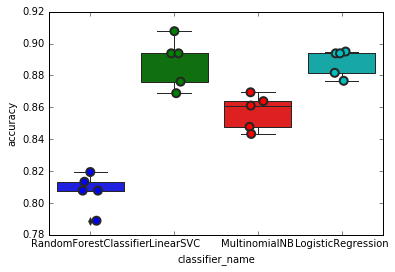

In [232]:
# Plot the classifiers accuracy
import seaborn as sns

sns.boxplot(x='classifier_name', y='accuracy', data=crossVal_df)
sns.stripplot(x='classifier_name', y='accuracy', data=crossVal_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [233]:
# Selecte the best classifier
model_classif_mean = crossVal_df.groupby('classifier_name').accuracy.mean()
print(model_classif_mean)
best_classif_name = model_classif_mean[model_classif_mean == model_classif_mean.max()].index[0]
for classifier in classifiers:
    if classifier.__class__.__name__ == best_classif_name:
        selected_classifier = classifier

classifier_name
LinearSVC                 0.888111
LogisticRegression        0.888222
MultinomialNB             0.857111
RandomForestClassifier    0.807444
Name: accuracy, dtype: float64


In [234]:
selected_classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [238]:
# Train the selected classifier and plot the actual vs predicted results
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, all_df.index, test_size=0.1, random_state=0)

selected_classifier.fit(X_train, y_train)
y_pred = selected_classifier.predict(X_test)

#selected_classifier.fit(X_train_tfidf, y_train)
#y_pred = selected_classifier.predict(count_vect.transform(X_test.values))


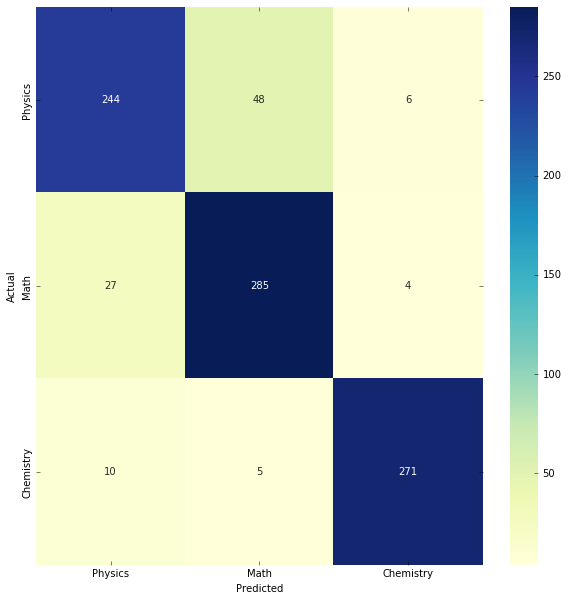

In [239]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred, labels = [0,1,2])

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d',
            xticklabels=['Physics', 'Math', 'Chemistry'], yticklabels=['Physics','Math', 'Chemistry'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [240]:
path = create_files()

In [241]:
classify_abstract(path, selected_classifier, tfidf)

In [242]:
len(os.listdir('Multi_abstracts_files/math_abstracts/'))

52

In [243]:
len(os.listdir('Multi_abstracts_files/chemistry_abstracts/'))

52

In [244]:
len(os.listdir('Multi_abstracts_files/physics_abstracts/'))

46